In [1]:
import sys, os, re, random, warnings, pickle
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
from numpy.random import shuffle
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from ssqa import *
from data import *
from pgm import *
from utils import *
from config import *

import sys

device = torch.device('cpu')
warnings.filterwarnings("ignore")
torch.cuda.is_available()

True

In [19]:
DATA = PFAM_DATA
DATASET = "PF00144"

batch_size = 300
q = 21
N = 31
k = 10
lamb_l1b = 0.025
gamma = lamb_l1b/(2*q*N)

## SS3 prediction

In [20]:
device = "cuda"
#DATA = PFAM_DATA

In [21]:
dataset = SSQAData_SSinf(f"{DATA}/{DATASET}/data.pt")
loader = DataLoader(dataset, batch_size = 1, 
                          shuffle = False, drop_last=False, collate_fn = collate_sequences)

Available :  seq L cluster_index weights subset seq_hmm pattern


In [6]:
N, q = 128, 50
# del model
# del model
model_ss = NetSurfP2(q, "nsp")
model_ss = model_ss.to(device)
optimizer = optim.Adam(model_ss.parameters(), lr=0.001)
model_ss.load_state_dict(torch.load(f"{UTILS}/nsp_50feats.h5"))

model_ss

Model nsp-50

In [25]:
ss3 = torch.zeros(len(dataset), 3, 500)
for batch_idx, data in enumerate(loader):
    x = torch.tensor(data[0]).float().cuda()
    ss_ = F.softmax(model_ss(x)[2],1).detach().cpu()
    ss3[1*batch_idx:1*(batch_idx+1), :, :ss_.size(-1)] = ss_
    if batch_idx == 1000:
        break

#torch.save(ss3, f"{DATA}/{DATASET}/ss3.pt")

In [28]:
ss3_max = ss3.permute(0, 2, 1)[:,200:300]

In [22]:
ss3_max.sum(-1)

tensor([[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [70]:
q, r

(1, 10)

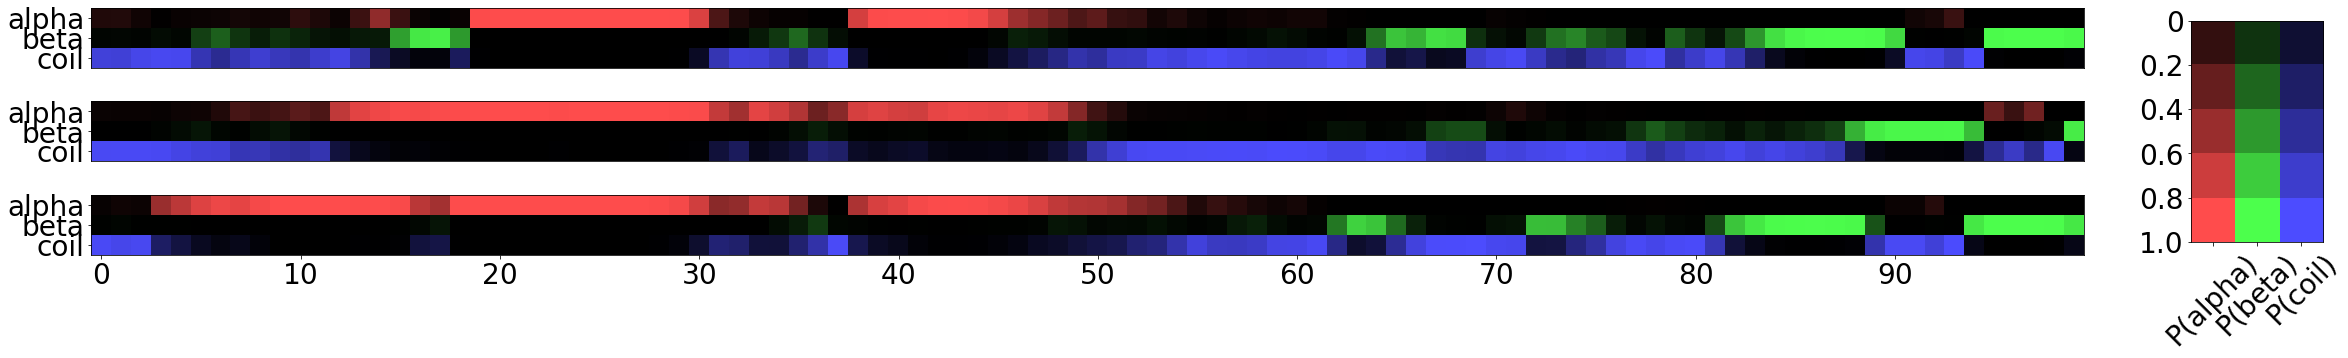

In [29]:
from matplotlib import gridspec 

def to_map(pot, k):
    mapping = np.ones((pot.shape[0],3))
    r,g,b = colors[k]
    p = pot[:,k]
    mapping[:,0] = r*p
    mapping[:,1] = g*p
    mapping[:,2] = b*p
    return mapping
fig = plt.figure(figsize= (40,5))

spec = gridspec.GridSpec(ncols=2, nrows=3, 
                         width_ratios=[15, 1], wspace=0.1, 
                         hspace=0.1, height_ratios=[1,1,1]) 


colors = [(1,0.3,0.3),
          (0.3,1,0.3), 
          (0.3,0.3,1), 
          (0.7,0.2,0.4), 
          (0.7,0.2,0.8), 
          (0.7,1,0), 
          (0,0,1), 
          (0,0.8,1)]

#colors = [(1.,0.,0.), (0.,1.,0.), (0.,0.,1.)]
SIZE = 100
idxs = np.random.choice(1000, 3)

for nrow, i in enumerate(idxs):
#     gt = np.array(val_dataset[i][2][:,-1],dtype=int)
    N = ss3_max[i].shape[0]
    q, r = N//SIZE, N%SIZE
    j = 0
    p = np.pad(ss3_max[i], ((0,(SIZE-r)%SIZE),(0,0)))
    mapping = np.array([to_map(p,i) for i in range(3)])
    ax = fig.add_subplot(spec[nrow,0]) 
    if nrow != 2:
        plt.xticks([],[])
    else:
        plt.xticks(list(range(0,SIZE,10)), list(range(SIZE*j,SIZE*(j+1),10)), fontsize = 28)
    plt.yticks([0,1,2],["alpha", "beta", "coil"], fontsize = 28)
    ax.imshow(mapping)
    
ax1 = fig.add_subplot(spec[:,1]) 
ax1.imshow(np.concatenate([color_map(0)[:,None], color_map(1)[:,None], color_map(2)[:,None]],1))
plt.yticks([-0.5,0.5,1.5,2.5,3.5,4.5],[0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize = 28)
plt.xticks([0, 1, 2],["P(alpha)", "P(beta)", "P(coil)"], rotation = 45, fontsize = 28)

plt.show()

In [11]:
def color_map(k):
    mapping = np.ones((5,3))
    r,g,b = colors[k]
    for i, p in enumerate([0.2,0.4,0.6,0.8,1]):
        mapping[i,0] = r*p
        mapping[i,1] = g*p
        mapping[i,2] = b*p
    return mapping

colors = [(1,0.3,0.3),
          (0.3,1,0.3), 
          (0.3,0.3,1), 
          (0.7,0.2,0.4), 
          (0.7,0.2,0.8), 
          (0.7,1,0), 
          (0,0,1), 
          (0,0.8,1)]


In [ ]:
plt.imshow(np.concatenate([color_map(0)[None], color_map(1)[None], color_map(2)[None]],0))
plt.xticks([-0.5,0.5,1.5,2.5,3.5,4.5],[0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize = 28)
plt.yticks([0, 1, 2],["P(alpha)", "P(beta)", "P(coil)"], fontsize = 28)


plt.show()

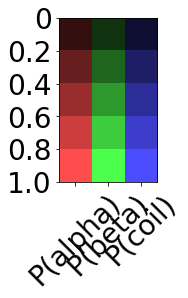

In [42]:
plt.subplot(131)
plt.imshow(np.concatenate([color_map(0)[:,None], color_map(1)[:,None], color_map(2)[:,None]],1))
plt.yticks([-0.5,0.5,1.5,2.5,3.5,4.5],[0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize = 28)
plt.xticks([0, 1, 2],["P(alpha)", "P(beta)", "P(coil)"], rotation = 45, fontsize = 28)

plt.show()

In [11]:
train_dataset = SecondaryStructureAnnotatedDataset(f"{UTILS}/training_set.pt", 50)
train_loader = DataLoader(train_dataset, batch_size = 15, collate_fn = collate_sequences_train,
                        shuffle = True, drop_last=True)

In [41]:
data = pickle.load(open(f"{UTILS}/validation_set", 'rb'))
data = [torch.tensor(v[0]).float() for v in data.values()]
torch.save(data, f"{UTILS}/validation_set.pt")